In [3]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from joblib import Parallel, delayed, dump, load
import albumentations as A

# ================== KONFIGURATION ==================
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'transform_sqrt': False,
    'block_norm': 'L2-Hys',
    'channel_axis': None
}

CHAR_MAPS = [
    ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"],
    list("ABCDEFGHJKLMNPQRSTUVWXYZ") + ["O"],
    *[list("ABCDEFGHJKLMNPQRSTUVWXYZ0123456789") + ["O"]] * 6  # Auf 6 erhöht für 8 Zeichen
]

AUGMENTER = A.Compose([
    A.Blur(blur_limit=3, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Perspective(scale=(0.01, 0.1), p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)
])

# ================== HELFERFUNKTIONEN ==================
def parse_labels(filename):
    """Extrahiert 8 Zeichenindizes aus dem Dateinamen"""
    filename = os.path.splitext(filename)[0]
    fields = filename.split('-')
    
    if len(fields) < 7:
        return None

    try:
        indices = list(map(int, fields[4].split('_')[:8]))  # 8 Indizes
        return [
            CHAR_MAPS[0][indices[0]],
            CHAR_MAPS[1][indices[1]],
            *[CHAR_MAPS[i+2][idx] for i, idx in enumerate(indices[2:8])]  # 6 alphanumerische Zeichen
        ]
    except:
        return None

def preprocess_image(img, filename):
    fields = filename.split('-')
    coord_str = fields[2]
    x1, y1 = map(int, coord_str.split('_')[0].split('&'))
    x2, y2 = map(int, coord_str.split('_')[1].split('&'))
    
    cropped = img[y1:y2, x1:x2]
    resized = cv2.resize(cropped, (240, 60))  # Angepasst für 8 Zeichen
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(gray, (3,3), 0)

# ================== DATENVERARBEITUNG ==================
def load_dataset(base_dir, split):
    file_path = os.path.join(base_dir, split, 'file_names.txt')
    image_dir = os.path.join(base_dir, split, 'images')
    
    with open(file_path) as f:
        filenames = [line.strip() for line in f]
    
    results = Parallel(n_jobs=-1)(
        delayed(process_image)(image_dir, fn, split) for fn in tqdm(filenames)
    )
    
    features = []
    labels = [[] for _ in range(8)]  # 8 Label-Listen
    
    for res in results:
        if res is not None:
            features.append(res[0])
            for i in range(8):  # 8 Positionen
                labels[i].append(res[1][i])
    
    return np.array(features), [np.array(l) for l in labels]

# ================== MODELLTRAINING ==================
def train_models(X_train, y_train):
    models = []
    for i in range(8):  # 8 Modelle
        print(f"\nTraining position {i} model...")
        model = SVC(
            kernel='rbf',
            C=10 if i < 2 else 5,
            gamma='scale',
            class_weight='balanced'
        )
        model.fit(X_train, y_train[i])
        dump(model, f'position_{i}_model.joblib')
        models.append(model)
    return models

# ================== EVALUIERUNG ==================
def evaluate(models, X_test, y_test):
    total_correct = 0
    char_acc = [0]*8  # 8 Positionen
    
    for feat, true_labels in zip(X_test, zip(*y_test)):
        pred = [model.predict([feat])[0] for model in models]
        
        for j in range(8):  # 8 Positionen
            if pred[j] == true_labels[j]:
                char_acc[j] += 1
        
        if all(p == t for p, t in zip(pred, true_labels)):
            total_correct += 1
            
    print("\nCharacter-wise Accuracy:")
    for j in range(8):  # 8 Positionen
        print(f"Position {j}: {char_acc[j]/len(X_test):.2%}")
    
    print(f"\nFull License Plate Accuracy: {total_correct/len(X_test):.2%}")

# ================== INFERENZ ==================
def predict_license_plate(img_path, models):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return None
    
    try:
        filename = os.path.basename(img_path)
        features = extract_features(img, filename)
        return ''.join([model.predict([features])[0] for model in models])
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return None

C:\Users\maure\AppData\Local\Temp\ipykernel_10156\1281447155.py:31: UserWarning: Argument 'var_limit' is not valid and will be ignored.
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5)


In [4]:
# ================== HAUPTPROGRAMM ==================
if __name__ == "__main__":
    BASE_DIR = "../dataset/CCPD2020/ccpd_green"
    
    # Daten laden
    print("Loading training data...")
    X_train, y_train = load_dataset(BASE_DIR, "train")
    
    print("\nLoading test data...")
    X_test, y_test = load_dataset(BASE_DIR, "test")
    
    # Training
    models = train_models(X_train, y_train)
    
    # Evaluation
    evaluate(models, X_test, y_test)
    
    # Beispiel-Inferenz
    test_img = os.path.join(BASE_DIR, "test/images/01-90_265-231&522_405&574-405&571_235&574_231&523_403&522-0_0_3_1_28_29_30_30-134-56.jpg")
    prediction = predict_license_plate(test_img, models)
    actual = ''.join(parse_labels(os.path.basename(test_img)))
    
    print(f"\nTest Prediction:\nPredicted: {prediction}\nActual:    {actual}")

Loading training data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5769/5769 [00:30<00:00, 189.15it/s]



Loading test data...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:06<00:00, 830.80it/s]



Training position 0 model...

Training position 1 model...

Training position 2 model...

Training position 3 model...

Training position 4 model...

Training position 5 model...

Training position 6 model...

Training position 7 model...

Character-wise Accuracy:
Position 0: 97.68%
Position 1: 97.14%
Position 2: 97.62%
Position 3: 57.13%
Position 4: 84.30%
Position 5: 84.86%
Position 6: 83.04%
Position 7: 80.34%

Full License Plate Accuracy: 39.89%

Test Prediction:
Predicted: 皖AD04566
Actual:    皖ADB4566


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5006/5006 [00:11<00:00, 419.66it/s]



Detaillierte Metriken pro Position:

Position 0:
  Precision: 97.15%
  Recall:    97.68%
  F1-Score:  97.03%
  Accuracy:  97.68%

Position 1:
  Precision: 96.53%
  Recall:    97.14%
  F1-Score:  96.13%
  Accuracy:  97.14%

Position 2:
  Precision: 97.53%
  Recall:    97.62%
  F1-Score:  97.48%
  Accuracy:  97.62%

Position 3:
  Precision: 46.39%
  Recall:    57.13%
  F1-Score:  47.10%
  Accuracy:  57.13%

Position 4:
  Precision: 85.47%
  Recall:    84.30%
  F1-Score:  84.39%
  Accuracy:  84.30%

Position 5:
  Precision: 85.40%
  Recall:    84.86%
  F1-Score:  84.87%
  Accuracy:  84.86%

Position 6:
  Precision: 84.23%
  Recall:    83.04%
  F1-Score:  83.12%
  Accuracy:  83.04%

Position 7:
  Precision: 81.25%
  Recall:    80.34%
  F1-Score:  80.42%
  Accuracy:  80.34%

Durchschnittliche Gesamtmetriken:
  Precision: 84.24%
  Recall:    85.27%
  F1-Score:  83.82%
  Accuracy:  85.27%


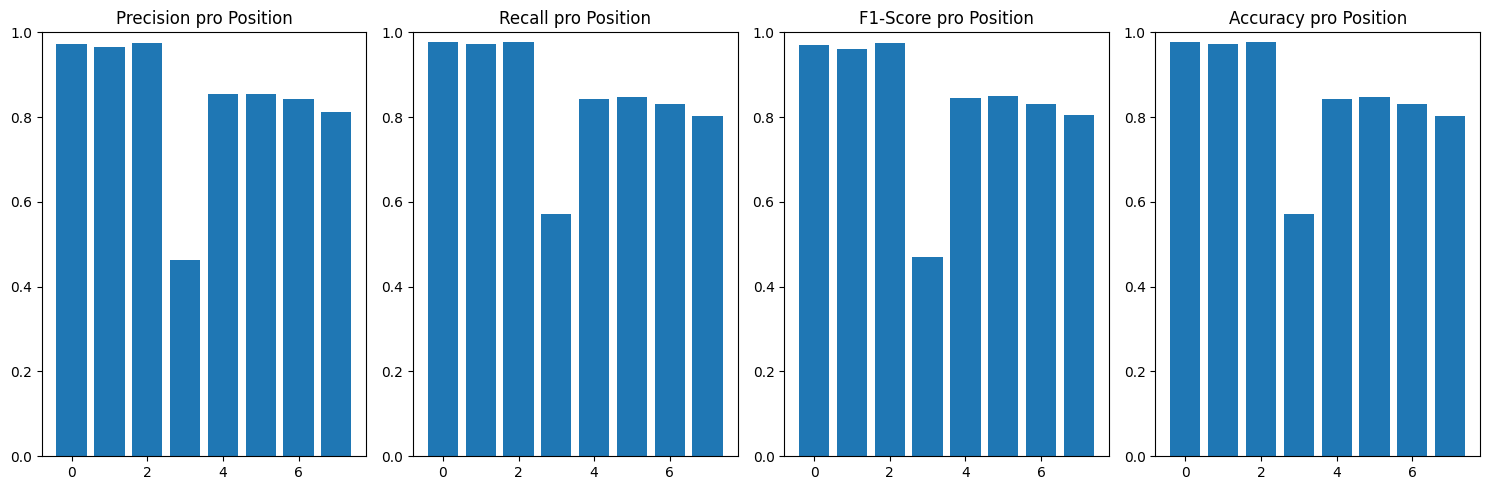

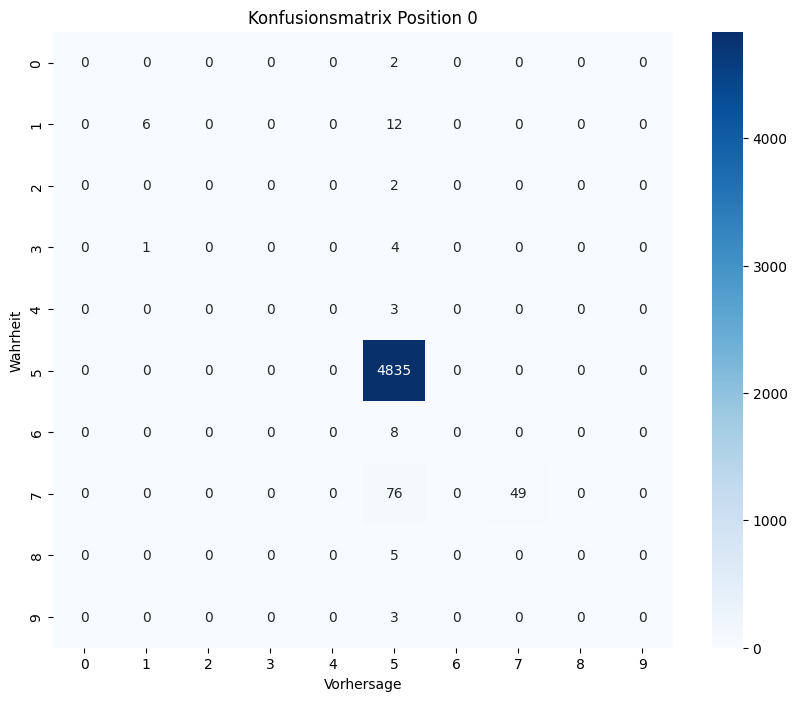

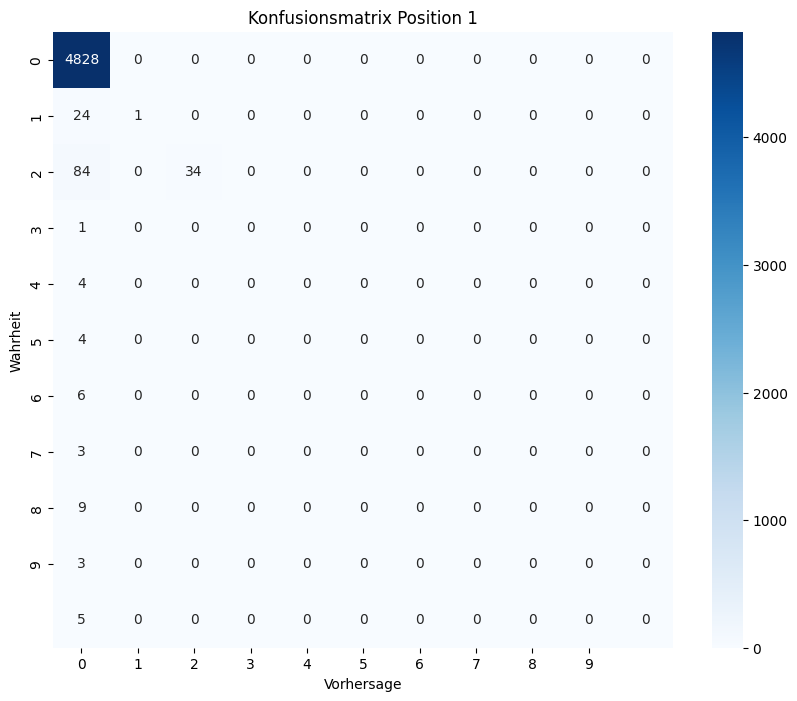


Durchschnittliche korrekte Zeichen pro Kennzeichen: 90.25%
Komplette Kennzeichen-Genauigkeit: 90.25%

Zusätzliche Beispielvorhersagen:
Could not read image: ../dataset/CCPD2020/ccpd_green\test/images\025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg

Bild: 025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg
Tatsächlich: 皖AY339S
Vorhergesagt: None
Keine Übereinstimmung


In [5]:
# ================== DETAILANALYSE DER VORHERSAGEN ==================
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from joblib import load
import seaborn as sns
import numpy as np
import os

def calculate_metrics(models, X_test, y_test):
    # Metriken pro Zeichenposition
    position_metrics = []
    
    for pos in range(8):
        y_true = y_test[pos]
        y_pred = models[pos].predict(X_test)
        
        # Metriken berechnen
        metrics = {
            'Position': pos,
            'Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'Recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'F1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'Accuracy': accuracy_score(y_true, y_pred)
        }
        position_metrics.append(metrics)
    
    # Gesamtmetriken
    total_metrics = {
        'Precision': np.mean([m['Precision'] for m in position_metrics]),
        'Recall': np.mean([m['Recall'] for m in position_metrics]),
        'F1': np.mean([m['F1'] for m in position_metrics]),
        'Accuracy': np.mean([m['Accuracy'] for m in position_metrics])
    }
    
    return position_metrics, total_metrics

def plot_position_metrics(position_metrics):
    positions = [m['Position'] for m in position_metrics]
    
    plt.figure(figsize=(15, 5))
    
    # Precision
    plt.subplot(1, 4, 1)
    plt.bar(positions, [m['Precision'] for m in position_metrics])
    plt.title('Precision pro Position')
    plt.ylim(0, 1)
    
    # Recall
    plt.subplot(1, 4, 2)
    plt.bar(positions, [m['Recall'] for m in position_metrics])
    plt.title('Recall pro Position')
    plt.ylim(0, 1)
    
    # F1-Score
    plt.subplot(1, 4, 3)
    plt.bar(positions, [m['F1'] for m in position_metrics])
    plt.title('F1-Score pro Position')
    plt.ylim(0, 1)
    
    # Accuracy
    plt.subplot(1, 4, 4)
    plt.bar(positions, [m['Accuracy'] for m in position_metrics])
    plt.title('Accuracy pro Position')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title(title)
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahrheit')
    plt.show()

def extended_analysis(models, X_test, y_test):
    # Berechnung der Metriken
    position_metrics, total_metrics = calculate_metrics(models, X_test, y_test)
    
    # Ausgabe der Ergebnisse
    print("\nDetaillierte Metriken pro Position:")
    for metric in position_metrics:
        print(f"\nPosition {metric['Position']}:")
        print(f"  Precision: {metric['Precision']:.2%}")
        print(f"  Recall:    {metric['Recall']:.2%}") 
        print(f"  F1-Score:  {metric['F1']:.2%}")
        print(f"  Accuracy:  {metric['Accuracy']:.2%}")
    
    print("\nDurchschnittliche Gesamtmetriken:")
    print(f"  Precision: {total_metrics['Precision']:.2%}")
    print(f"  Recall:    {total_metrics['Recall']:.2%}")
    print(f"  F1-Score:  {total_metrics['F1']:.2%}")
    print(f"  Accuracy:  {total_metrics['Accuracy']:.2%}")
    
    # Visualisierung
    plot_position_metrics(position_metrics)
    
    # Beispiel-Konfusionsmatrix für Position 0 und 1
    for pos in [0, 1]:
        y_true = y_test[pos]
        y_pred = models[pos].predict(X_test)
        plot_confusion_matrix(y_true, y_pred, 
                             classes=[str(i) for i in range(10)],  # Klassen anpassen
                             title=f'Konfusionsmatrix Position {pos}')

def calculate_full_accuracy(models, X_test, y_test):
    correct = 0
    total_chars = 0
    
    for feat, true_labels in zip(X_test, zip(*y_test)):
        pred = [model.predict([feat])[0] for model in models]
        correct += sum(p == t for p, t in zip(pred, true_labels))
        if all(p == t for p, t in zip(pred, true_labels)):
            correct += 1
        total_chars += 8
    
    print(f"\nDurchschnittliche korrekte Zeichen pro Kennzeichen: {correct/total_chars:.2%}")
    print(f"Komplette Kennzeichen-Genauigkeit: {correct/ (8 * len(X_test)):.2%}")

def load_and_test_models(base_dir):
    # Modelle laden
    models = [load(f'position_{i}_model.joblib') for i in range(8)]
    
    # Testdaten laden
    X_test, y_test = load_dataset(base_dir, "test")
    
    # 1. Detailanalyse
    extended_analysis(models, X_test, y_test)
    
    # 2. Vollständige Genauigkeit
    calculate_full_accuracy(models, X_test, y_test)
    

BASE_DIR = "../dataset/CCPD2020/ccpd_green"
load_and_test_models(BASE_DIR)
